### Multi-Conditional Graph Variational Autoencoder

In [1]:
!git clone https://github.com/Raiden-Makoto/MCGVAE.git

Cloning into 'MCGVAE'...
remote: Enumerating objects: 2300, done.
remote: Counting objects: 100% (2300/2300), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 2300 (delta 2205), reused 2256 (delta 2169), pack-reused 0 (from 0)
Receiving objects: 100% (2300/2300), 14.08 MiB | 11.43 MiB/s, done.
Resolving deltas: 100% (2205/2205), done.


In [2]:
%cd MCGVAE

/kaggle/working/MCGVAE


In [3]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 9.0 MB/s eta 0:00:00
ERROR: Ignored the following versions that require a different python version: 0.13.0 Requires-Python <3.11,>=3.7; 0.36.0 Requires-Python >=3.6,<3.10; 0.37.0 Requires-Python >=3.7,<3.10; 0.38.0 Requires-Python >=3.7,<3.11; 0.38.1 Requires-Python >=3.7,<3.11; 0.52.0 Requires-Python >=3.6,<3.9; 0.52.0rc3 Requires-Python >=3.6,<3.9; 0.53.0 Requires-Python >=3.6,<3.10; 0.53.0rc1.post1 Requires-Python >=3.6,<3.10; 0.53.0rc2 Requires-Python >=3.6,<3.10; 0.53.0rc3 Requires-Python >=3.6,<3.10; 0.53.1 Requires-Python >=3.6,<3.10; 0.54.0 Requires-Python >=3.7,<3.10; 0.54.0rc2 Requires-Python >=3.7,<3.10; 0.54.0rc3 Requires-Python >=3.7,<3.10; 0.54.1 Requires-Python >=3.7,<3.10; 0.55.0 Requires-Python >=3.7,<3.11; 0.55.0rc1 Requires-Python >=3.7,<3.11; 0.55.1

In [4]:
!pip -q install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 52.9 MB/s eta 0:00:00


In [5]:
!pip -q install torch_geometric torch-scatter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.7 MB/s eta 0:00:00


In [6]:
import torch
#device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
from data.dataset import QM9GraphDataset
from utils.datautils import create_data_loaders
from mgcvae import MGCVAE
from trainer import MGCVAETrainer
from utils.trainutils import load_from_checkpoint

In [8]:
dataset = QM9GraphDataset(csv_path='./data/qm9_bbbp2.csv')

Processing...


Processing 4898 molecules...
Successfully processed 4898 molecules, failed: 0


Done!


In [9]:
train_loader, val_loader, test_loader = create_data_loaders(dataset, batch_size=4)

Dataset splits — Train: 3918, Val: 490, Test: 490


In [10]:
loaded = False

In [11]:
# Load the best model from training
if loaded:
    model, optimizer_state, scheduler_state, checkpoint = load_from_checkpoint(
        'checkpoints/mgcvae/best_model.pth',
        device=device
    )
    # Model is ready for inference!
    # You can also access training history:
    print(f"\nTraining stopped at epoch: {checkpoint['epoch']}")
    print(f"Final validation loss: {checkpoint['best_val_loss']:.4f}")

In [12]:
if not loaded:
    model_config = {
        'node_dim': 29,
        'edge_dim': 6,
        'latent_dim': 32,
        'hidden_dim': 64,
        'num_properties': 1,
        'num_layers': 3,
        'heads': 4,
        'max_nodes': 20,
        'beta': 0.01,      # Start with low KL weight
        'gamma': 1.0,      # Property prediction weight
        'dropout': 0.1
    }
    model = MGCVAE(**model_config).to(device)

In [13]:
trainer = MGCVAETrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    lr=1e-3,
    device=device,
    save_dir='checkpoints/mgcvae'
)

In [14]:
if loaded: trainer.load_optimizer_scheduler(optimizer_state, scheduler_state)

Starting MGCVAE training from epoch 0 to 9
Model parameters: 105,216
Device: cuda

Epoch 0/9


Validation: 100%|██████████| 123/123 [00:21<00:00,  5.65it/s]


New best model saved! Val loss: 1.0751
Train Loss: 1.3690 | Val Loss: 1.0751
Recon: 1.2026 | KL: 3.1970 | Prop: 0.1345
LR: 1.00e-03 | Patience: 0/30

Epoch 1/9


Validation: 100%|██████████| 123/123 [00:21<00:00,  5.66it/s]


New best model saved! Val loss: 1.0192
Train Loss: 1.1014 | Val Loss: 1.0192
Recon: 0.9595 | KL: 2.7503 | Prop: 0.1144
LR: 1.00e-03 | Patience: 0/30

Epoch 2/9


Validation: 100%|██████████| 123/123 [00:21<00:00,  5.65it/s]


New best model saved! Val loss: 1.0141
Train Loss: 1.0787 | Val Loss: 1.0141
Recon: 0.9423 | KL: 2.5172 | Prop: 0.1112
LR: 1.00e-03 | Patience: 0/30

Epoch 3/9


Validation: 100%|██████████| 123/123 [00:21<00:00,  5.65it/s]


New best model saved! Val loss: 1.0032
Train Loss: 1.0713 | Val Loss: 1.0032
Recon: 0.9356 | KL: 2.5053 | Prop: 0.1107
LR: 1.00e-03 | Patience: 0/30

Epoch 4/9


Validation: 100%|██████████| 123/123 [00:21<00:00,  5.68it/s]


New best model saved! Val loss: 0.9960
Train Loss: 1.0564 | Val Loss: 0.9960
Recon: 0.9233 | KL: 2.2873 | Prop: 0.1103
LR: 1.00e-03 | Patience: 0/30

Epoch 5/9


Validation: 100%|██████████| 123/123 [00:21<00:00,  5.66it/s]


Train Loss: 1.0433 | Val Loss: 1.0537
Recon: 0.9129 | KL: 2.1149 | Prop: 0.1092
LR: 1.00e-03 | Patience: 1/30

Epoch 6/9


Validation: 100%|██████████| 123/123 [00:21<00:00,  5.64it/s]


New best model saved! Val loss: 0.9893
Train Loss: 1.0346 | Val Loss: 0.9893
Recon: 0.9060 | KL: 1.9301 | Prop: 0.1094
LR: 1.00e-03 | Patience: 0/30

Epoch 7/9


Validation: 100%|██████████| 123/123 [00:21<00:00,  5.64it/s]


New best model saved! Val loss: 0.9879
Train Loss: 1.0314 | Val Loss: 0.9879
Recon: 0.9050 | KL: 1.7816 | Prop: 0.1086
LR: 1.00e-03 | Patience: 0/30

Epoch 8/9


Validation: 100%|██████████| 123/123 [00:21<00:00,  5.69it/s]


New best model saved! Val loss: 0.9735
Train Loss: 1.0262 | Val Loss: 0.9735
Recon: 0.8996 | KL: 1.7497 | Prop: 0.1091
LR: 1.00e-03 | Patience: 0/30

Epoch 9/9


Validation: 100%|██████████| 123/123 [00:21<00:00,  5.67it/s]


Train Loss: 1.0228 | Val Loss: 0.9746
Recon: 0.8970 | KL: 1.7168 | Prop: 0.1086
LR: 1.00e-03 | Patience: 1/30


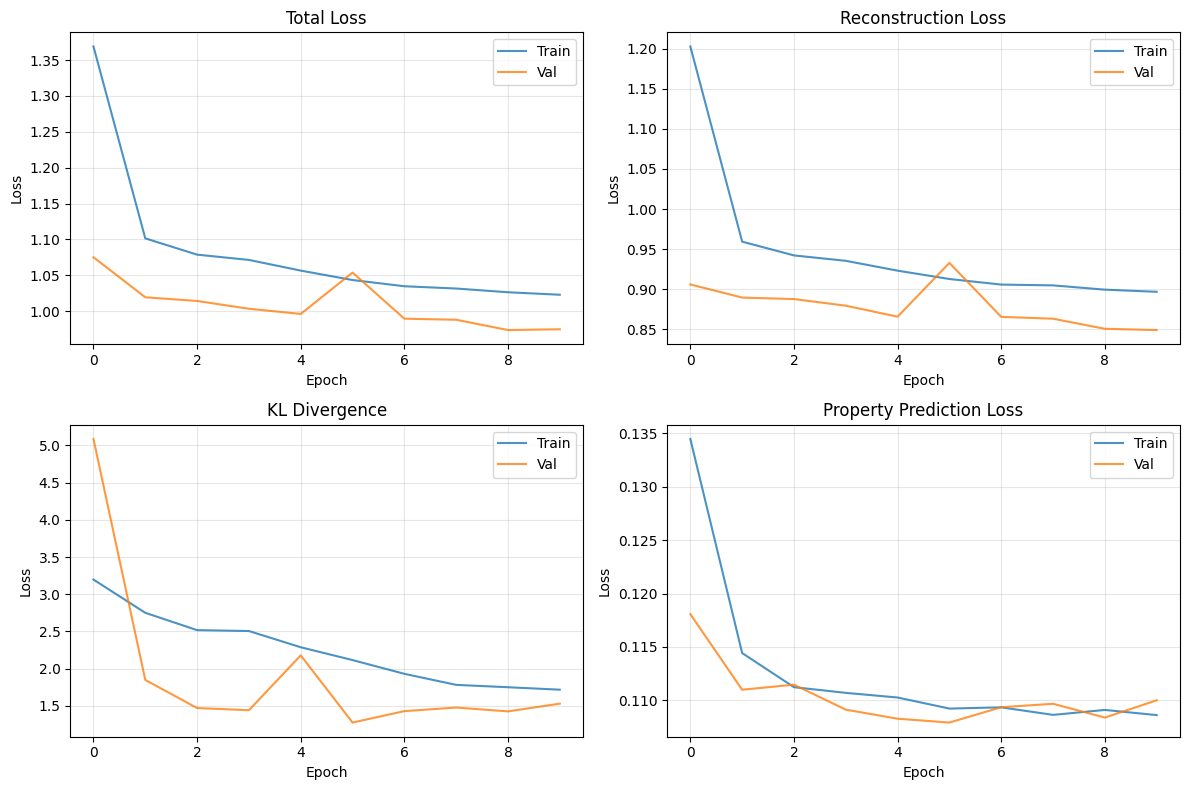

Training completed!


In [15]:
train_metrics, val_metrics = trainer.train(num_epochs=10, start_epoch=0 if not loaded else checkpoint['epoch']+1)

### Metrics

In [16]:
from utils.metrics import (
    evaluate_property_prediction,
    evaluate_reconstruction_and_kl,
    evaluate_novelty_diversity,
    evaluate_conditioning_latent
)

In [17]:
from utils.inference import (
    batch_logits_to_molecules,
    evaluate_generation_quality
)

In [18]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [19]:
_ = evaluate_property_prediction(model, val_loader, device)
_ = evaluate_reconstruction_and_kl(model, val_loader, device)

Property Prediction MSE: 0.4396
Avg Reconstruction Loss: 0.8493
Avg KL Divergence: 1.5293


In [20]:
evaluate_conditioning_latent(model, target=[0.9], num_samples=20, tolerance=0.15, device=device)

Conditioning Evaluation (latent):
Target:            [0.9]
Success rate:      0.0% within ±0.15
Mean absolute err: 0.2472
Predicted mean:    [0.6527858972549438]
  Predicted std:     [0.018461933359503746]


{'success_rate': 0.0,
 'mae': 0.2472141146659852,
 'mean_pred': [0.6527858972549438],
 'std_pred': [0.018461933359503746]}

### Inference
Once the metrics are within reasonable thresholds, we can conditionally generate new molecules